In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        for label in os.listdir(data_path):
            if label == 'cat':
                class_label = 0
            elif label == 'dog':
                class_label = 1
            else:
                continue
            for image_file in os.listdir(os.path.join(data_path, label)):
                self.images.append(os.path.join(data_path, label, image_file))
                self.labels.append(class_label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        # Ensure that the image is in RGB format
        image = image.convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])


In [ ]:
data_path = '/content/drive/MyDrive/Dogs/d3_train'

dataset = CustomDataset(data_path, transform=transform)

import random
from torch.utils.data import Subset

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

# Define the split ratio for validation and test sets
validation_ratio = 0.1  # 20% of the data for validation
test_ratio = 0.2       # 20% of the data for testing

# Calculate the number of samples for validation and test sets
total_samples = len(dataset)
num_validation_samples = min(int(validation_ratio * total_samples), total_samples // 2)
num_test_samples = min(int(test_ratio * total_samples), total_samples // 2)

# Create an index list for shuffling
indices_3 = list(range(total_samples))
random.shuffle(indices_3)

# Split the indices into validation and test sets while maintaining class balance
train_indices = []
validation_indices = []
test_indices = []
indices_2 = []
v_num_cat = 0
v_num_dog = 0
t_num_cat = 0
t_num_dog = 0

for idx in indices_3:
    label = dataset.labels[idx]
    if label == 0 and v_num_cat < num_validation_samples / 2:
        validation_indices.append(idx)
        v_num_cat += 1
    elif label == 1 and v_num_dog < num_validation_samples / 2:
        validation_indices.append(idx)
        v_num_dog += 1
    else:
        indices_2.append(idx)

for idx in indices_2:
    label = dataset.labels[idx]
    if label == 0 and t_num_cat < num_test_samples / 2:
        test_indices.append(idx)
        t_num_cat += 1
    elif label == 1 and t_num_dog < num_test_samples / 2:
        test_indices.append(idx)
        t_num_dog += 1
    else:
        train_indices.append(idx)

# Create custom datasets for validation and test sets
training_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)
test_dataset = Subset(dataset, test_indices)

print("Train_samples: " + str(len(training_dataset)))
print("Validation_samples: " + str(len(validation_dataset)))
print("Test_samples: " + str(len(test_dataset)))


# Create data loaders for validation and test sets
train_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)



Train_samples: 700
Validation_samples: 100
Test_samples: 200


In [ ]:
# Define the CNN model
class CNNwithSE(nn.Module):
    def __init__(self):
        super(CNNwithSE, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        # self.flatten = nn.Flatten()
        # self.fc = nn.Linear(64 * 8 * 8, 2)  # Assuming output size 2 for binary classification
        self.se = SEBlock(64)  # SE block with 64 channels

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        # x = self.flatten(x)
        # x = self.fc(x)
        x = self.se(x)
        return x

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, channel, height, width = x.size()
        y = self.avg_pool(x).view(batch_size, channel) #excitation block
        y = self.fc(y).view(batch_size, channel, 1, 1) #squeeze block
        return x * y.expand_as(x)  #scaling

In [ ]:
class SEResNet(nn.Module):
    def __init__(self):
        super(SEResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Modify layers to preserve the output shape
        self.resnet.layer4[0].conv2.stride = (1, 1)
        self.resnet.layer4[0].downsample[0].stride = (1, 1)
        self.resnet.layer4[0].conv3.stride = (1, 1)

        self.additional_conv = nn.Conv2d(2048, 64, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((8, 8)) # Reshape the output from (1,64,14,14) to (1,64,8,8)
        self.se = SEBlock(64)  # SE block with 64 channels

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        # Additional convolutional layer to adjust the number of output channels
        x = self.additional_conv(x)
        x = self.avgpool(x)
        x = self.se(x)

        return x


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(704 * 8 * 8, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  # Output has 2 nodes for the two classes
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
class LAG(nn.Module):
    def __init__(self):
        super(LAG, self).__init__()
        self.cnn_se_model = CNNwithSE()
        self.backbone = SEResNet()
        self.classifier = Classifier()

    def forward(self, image):
        sub_module_outputs = []
        for i in range(10):
            crop_transform = transforms.RandomCrop(64)
            cropped_image = crop_transform(image)
            output = self.cnn_se_model(cropped_image)
            sub_module_outputs.append(output)

        ensemble_sub_module = torch.cat(sub_module_outputs, dim=1)

        resize_data = transforms.Resize((224, 224))
        resized_image = resize_data(image)
        backbone_output = self.backbone(resized_image)

        concatenated_output = torch.cat((backbone_output, ensemble_sub_module), dim=1)

        lag_output = self.classifier(concatenated_output)
        return lag_output

In [ ]:
model = LAG()
loss_function = nn.BCEWithLogitsLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [ ]:
path = "/content/drive/MyDrive/model/tl3_50e_lag_model.pth"
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Check if a checkpoint exists to resume training
if os.path.exists(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
  train_losses = checkpoint["train_loss"]
  val_losses = checkpoint["valid_loss"]
  train_accuracy = checkpoint['t_accuracy']
  val_accuracy = checkpoint['v_accuracy']
  start_epoch = checkpoint["epoch"] + 1  # Start from the next epoch after the loaded checkpoint
  print("Resume training from epoch", start_epoch)
else:
  start_epoch = 1

In [ ]:
import time

# Define accuracy calculation function
def calculate_accuracy(predictions, labels):
    predicted_labels = (predictions > 0.5).int()
    correct = (predicted_labels == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

total_epochs = 50
for epoch in range(start_epoch, total_epochs + 1):
    model.train()
    s_time = time.time()
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    for batch_idx, (image, label) in enumerate(test_dataloader):
        prediction = model(image)
        prediction = prediction.squeeze(1)
        tloss = loss_function(prediction, label.float())
        train_loss += tloss.item()
        train_correct += calculate_accuracy(prediction, label)

        optimizer.zero_grad()
        tloss.backward()
        optimizer.step()

    train_loss /= len(test_dataloader)
    t_accuracy = train_correct / len(test_dataloader)

    train_losses.append(train_loss)
    train_accuracy.append(t_accuracy)

    with torch.no_grad():
        for batch, (img, lbl) in enumerate(validation_dataloader):
            prediction = model(img)
            prediction = prediction.squeeze(1)
            vloss = loss_function(prediction, lbl.float())
            val_loss += vloss.item()
            val_correct += calculate_accuracy(prediction, lbl)

    val_loss /= len(validation_dataloader)
    v_accuracy = val_correct / len(validation_dataloader)
    val_losses.append(val_loss)
    val_accuracy.append(v_accuracy)

    print(f'Epoch [{epoch}/{total_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {t_accuracy * 100:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {v_accuracy * 100:.2f}%, Time: {time.time() - s_time:.2f} sec')

    # Save model checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_loss': val_losses,
        't_accuracy': train_accuracy,
        'v_accuracy': val_accuracy,
    }
    torch.save(checkpoint, path)


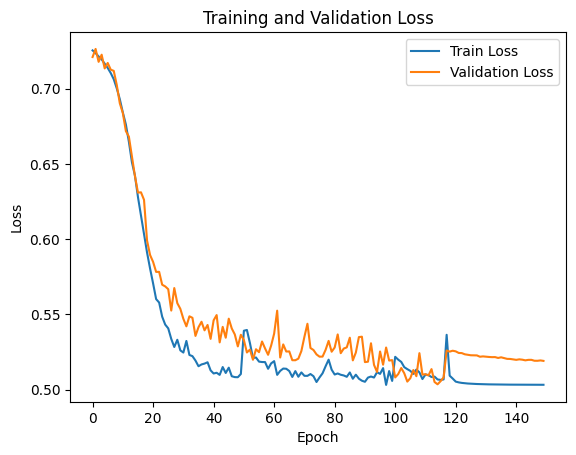

In [ ]:
# Plot the loss graph
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

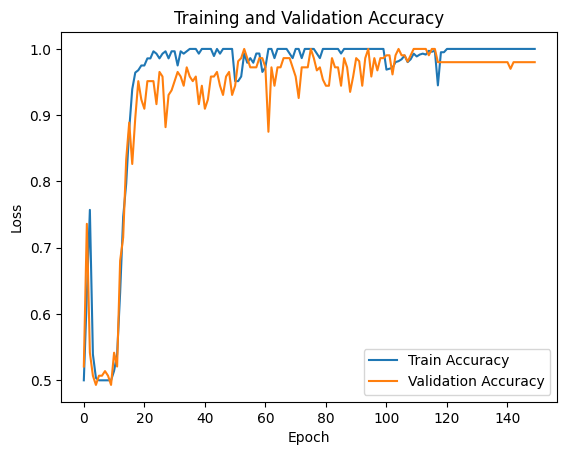

In [ ]:
# Plot the loss graph
plt.figure()
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
model.eval()
test_correct = 0
labels = []
test_predictions = []
with torch.no_grad():
    for image, label in train_dataloader:
        predictions = model(image)
        prediction = predictions.squeeze(1)
        test_correct += calculate_accuracy(prediction, label)

        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(predictions)
        predicted_labels = (probabilities > 0.6).int()
        labels.append(label)
        test_predictions.append(predicted_labels)

    test_accuracy = test_correct / len(train_dataloader)

    print(f"Accuracy: {test_accuracy * 100:.2f}%")



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 99.86%


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
model.eval()
labels = []
test_predictions = []
with torch.no_grad():
    for image, label in validation_dataloader:
        predictions = model(image)
        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(predictions)
        predicted_labels = (probabilities > 0.6).int()
        labels.append(label)
        test_predictions.append(predicted_labels)
        # print("predicted label : ",predicted_labels)

    labels_flat = [label.item() for batch_labels in labels for label in batch_labels]
    test_predictions_flat = [pred.item() for batch_predictions in test_predictions for pred in batch_predictions]

    labels_flat = np.array(labels_flat)
    test_predictions_flat = np.array(test_predictions_flat)

    accuracy = accuracy_score(labels_flat, test_predictions_flat)

    print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 97.00%
